# AI Agents in LangGraph

**This Notebook is replication of demo shown in https://www.deeplearning.ai/short-courses/ai-agents-in-langgraph/**

## Build an Agent From Scratch

- Paper Link: https://arxiv.org/abs/2210.03629
- ReAct: Synergizing Reasoning and Acting in Language Models

In [1]:
import os
from getpass import getpass
import openai
import re
import httpx

In [2]:
os.environ['OPENAI_API_KEY'] = getpass()

 ········


In [3]:
# Intantiate LLM
from openai import OpenAI

client = OpenAI()

In [4]:
# Test
chat_completion = client.chat.completions.create(
    model="gpt-3.5-turbo", 
    messages=[{"role": "user", "content": "Hello World"}]
)

In [5]:
chat_completion.choices[0].message.content

'Hello! How are you today?'

In [6]:
class Agent:
    def __init__(self, system=""): # Parameterized System message from User
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})
    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result
    def execute(self):
        completion = client.chat.completions.create(
            model="gpt-4-0125-preview", 
            temperature=0, 
            messages=self.messages
        )
        return completion.choices[0].message.content

In [7]:
# Prompt for ReAct
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

In [8]:
# Functions
def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [9]:
abot = Agent(prompt)

In [10]:
result = abot("How much does a toy poodle weigh?")
print(result)

Thought: I should look up the dog's weight using average_dog_weight for a Toy Poodle.
Action: average_dog_weight: Toy Poodle
PAUSE


In [11]:
result = average_dog_weight("Toy Poodle")
result

'a toy poodles average weight is 7 lbs'

In [12]:
next_prompt = f"Observation: {result}"
abot(next_prompt)

"Answer: A Toy Poodle's average weight is 7 lbs."

In [13]:
abot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'},
 {'role': 'user', 'content': 'How much does a 

In [14]:
# Different example
abot = Agent(prompt)
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
abot(question)

"Thought: To find the combined weight of a Border Collie and a Scottish Terrier, I need to find the average weight of each breed and then add those weights together. I'll start by finding the average weight of a Border Collie.\nAction: average_dog_weight: Border Collie\nPAUSE"

In [15]:
next_prompt = f"Observation: {average_dog_weight('Border Collie')}"
print(next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [16]:
abot(next_prompt)

'Thought: Now that I know the average weight of a Border Collie is 37 lbs, I need to find the average weight of a Scottish Terrier to calculate the combined weight.\nAction: average_dog_weight: Scottish Terrier\nPAUSE'

In [17]:
next_prompt = f"Observation: {average_dog_weight('Scottish Terrier')}"
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


In [18]:
abot(next_prompt)

'Thought: With the average weight of a Border Collie being 37 lbs and a Scottish Terrier being 20 lbs, I can now calculate their combined weight by adding these two numbers together.\nAction: calculate: 37 + 20\nPAUSE'

In [19]:
next_prompt = f"Observation: {eval('37 + 20')}"
print(next_prompt)

Observation: 57


In [20]:
abot(next_prompt)

'Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.'

### Automate the Agent

In [21]:
# Regex to determine if an action is required or is it the final answer.
action_re = re.compile('^Action: (\w+): (.*)$')

In [22]:
def query(question, max_turns=5):
    i = 0 # Counter to keep track of iteration
    bot = Agent(prompt) # Instantiate the Agent
    next_prompt = question # Keep track of what to pass to the agent
    # Start loop
    while i < max_turns:
        i += 1 # Increment the counter
        result = bot(next_prompt) # Get result from Agent
        print(result)
        # Parse response from Agent
        actions = [
            action_re.match(a)
            for a in result.split('\n')
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception(f"Unknown action: {action}: {action_input}")
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return

In [23]:
question = """I have two dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)

Thought: To find the combined weight of a Border Collie and a Scottish Terrier, I need to find the average weight of each breed and then add those weights together.
Action: average_dog_weight: Border Collie
PAUSE
 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs
Action: average_dog_weight: Scottish Terrier
PAUSE
 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs
Thought: Now that I have the average weights of both a Border Collie and a Scottish Terrier, I can calculate their combined weight by adding the two weights together.
Action: calculate: 37 + 20
PAUSE
 -- running calculate 37 + 20
Observation: 57
Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.


## LangGraph Components

- LangGraph is an extension of LangChain that supports graphs.
- Single and Multi-agent flows are described and represented as graphs.
- Allows for extremely controlled "flows".
- Built-in persistence allows for human-in-the-loop workflows.
- Cyclic Graph
    - Nodes: Agents or Functions
    - Edges: Connect Nodes
    - Conditional Edges: Decisions
- Data/State
    - Agent State is accessible to all parts of the graph.
    - It is local to the graph.
    - Can be stored in a persistence layer.
- Persistence
- Human-in-the-loop

In [24]:
import os

os.environ['TAVILY_API_KEY'] = getpass()

 ········


In [61]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [26]:
tavily_tool = TavilySearchResults(max_results=4)
print(type(tavily_tool))
print(tavily_tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [27]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [28]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", 
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:
                print("\n ...bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [29]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tavily_tool], system=prompt)

In [30]:
messages = [HumanMessage(content="What is the weather in Bengaluru, India?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bengaluru, India'}, 'id': 'call_Wx3USbe7OlHbySE6LpDEQXxC'}
Back to the model!


In [31]:
result

{'messages': [HumanMessage(content='What is the weather in Bengaluru, India?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Wx3USbe7OlHbySE6LpDEQXxC', 'function': {'arguments': '{"query":"weather in Bengaluru, India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 156, 'total_tokens': 179}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-20bead3b-05c5-4ee6-b501-df230478b019-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bengaluru, India'}, 'id': 'call_Wx3USbe7OlHbySE6LpDEQXxC'}]),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Bengaluru\', \'region\': \'Karnataka\', \'country\': \'India\', \'lat\': 12.98, \'lon\': 77.58, \'tz_id\': \'Asia/Kolkata\', \'localtime_epoch\': 1718615359, \'localtime\': \'20

In [32]:
result['messages'][-1].content

'The current weather in Bengaluru, India is partly cloudy with a temperature of 31.1°C (88.0°F). The wind speed is 5.6 mph, and the humidity is 63%.'

In [33]:
query = "Who won Indian Premier League in 2023? What is the current GDP of that State?"
messages = [HumanMessage(content=query)]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Indian Premier League winner 2023'}, 'id': 'call_ug6NPt5StlheDJiU6B0vuxn9'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current GDP of the State that won Indian Premier League 2023'}, 'id': 'call_HpkwAMpUb5uFpf1aXrQ22QMy'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current GDP of Chennai State'}, 'id': 'call_9AdugnCq1SHbB8GbU30xeqzh'}
Back to the model!


In [34]:
result['messages'][-1].content

'The GDP of Chennai, the capital city of the Indian state of Tamil Nadu, was estimated to be around $128.3 billion.'

## Persistence And Streaming

In [35]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [36]:
# Modification to Agent Class
class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", 
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:
                print("\n ...bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [38]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tavily_tool], system=prompt, checkpointer=memory)

### Message Streaming

In [39]:
messages = [HumanMessage(content="What is the weather in Bengaluru, India?")]

In [40]:
thread = {"configurable": {"thread_id": "1"}}

In [41]:
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d4t4R136msW3K3HjsjvBLctV', 'function': {'arguments': '{"query":"weather in Bengaluru, India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 156, 'total_tokens': 179}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-35f4082d-0ace-4bbf-8dcb-3b6f901ad4b4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bengaluru, India'}, 'id': 'call_d4t4R136msW3K3HjsjvBLctV'}])]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bengaluru, India'}, 'id': 'call_d4t4R136msW3K3HjsjvBLctV'}
Back to the model!
[ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Bengaluru\', \'region\': \'Karnataka\', \'country\': \'India\', \'lat\': 12.98, \'lon\': 77.58, \'tz_id

In [42]:
messages = [HumanMessage(content="What about Patna?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qvLumrdFTLkCez4K5n7VTMuI', 'function': {'arguments': '{"query":"weather in Patna, India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1113, 'total_tokens': 1136}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cd0c6a57-7432-4128-8da9-c1836e850ce8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Patna, India'}, 'id': 'call_qvLumrdFTLkCez4K5n7VTMuI'}])]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Patna, India'}, 'id': 'call_qvLumrdFTLkCez4K5n7VTMuI'}
Back to the model!
[ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Patna\', \'region\': \'Bihar\', \'country\': \'India\', \'lat\': 25.6, \'lon\': 85.12, \'tz_id\': \'Asia/Kolkata\

In [43]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='Patna is currently warmer than Bengaluru. The temperature in Patna is 37.0°C (98.6°F) while the temperature in Bengaluru is 31.1°C (88.0°F).', response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 2111, 'total_tokens': 2156}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-e7eff8c4-1199-4abb-8793-c7ff84eddf51-0')]


### Token Streaming

In [45]:
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver

memory = AsyncSqliteSaver.from_conn_string(":memory:")
abot = Agent(model, [tavily_tool], system=prompt, checkpointer=memory)

In [48]:
messages = [HumanMessage(content="What is the weather in Bengaluru, India?")]
thread = {"configurable": {"thread_id": "2"}}
async for event in abot.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event['event']
    if kind == "on_chat_model_stream":
        content = event['data']['chunk'].content
        if content:
            print(content, end="|")

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bengaluru, India'}, 'id': 'call_cpOmn7vYwODpjoHTjlmaqmXo'}
Back to the model!


## Human in the Loop

In [50]:
from uuid import uuid4

"""
In Previous examples, the 'messages' state key were annotated
with the default 'operator.add' or '+' reducer, which always
appends new messages to the end of the existing messages array.

To support replacing existing messages, we annotate the 'messages'
key with a custom reducer function, which replaces messages with the same 'id'
and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # Assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # Merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # Replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # Append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [51]:
# Modification to Agent Class
class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", 
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer, 
            interrupt_before=['action'])
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:
                print("\n ...bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [55]:
memory = SqliteSaver.from_conn_string(":memory:")

tavily_tool = TavilySearchResults(max_results=4)

prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-4-turbo")
abot = Agent(model, [tavily_tool], system=prompt, checkpointer=memory)
messages = [HumanMessage(content="Whats the weather in Delhi?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Mjtawc8W8YBxZAJQgVKICzvS', 'function': {'arguments': '{"query":"current weather in Delhi"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-4-turbo', 'system_fingerprint': 'fp_9d7f5c6195', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dde992ff-fb7e-4878-8a8d-e74bf8f1aefe-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Delhi'}, 'id': 'call_Mjtawc8W8YBxZAJQgVKICzvS'}])]


## Essay Writer

In [59]:
# Set in memory checkpoint
memory = SqliteSaver.from_conn_string(":essay_memory:")

In [62]:
# Create Agent State
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [63]:
# Instantiate LLM
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [64]:
# Create Planning Prompt
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections.
"""

In [65]:
# Create Writer Prompt
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays. \
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

In [66]:
# Create Reflection prompt
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [67]:
# Create Research prompt
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""

In [68]:
# Create Critique Prompt
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing more information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""

In [70]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [71]:
from tavily import TavilyClient

tavily = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])

In [72]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [73]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [74]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is the plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ), 
        user_message
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

In [75]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [76]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT), 
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [77]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [78]:
# Initialize Graph with AgentState
builder = StateGraph(AgentState)

In [79]:
# Add different nodes
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [80]:
# Set Entry Point
builder.set_entry_point("planner")

In [81]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)

In [82]:
# Add edges
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [83]:
graph = builder.compile(checkpointer=memory)

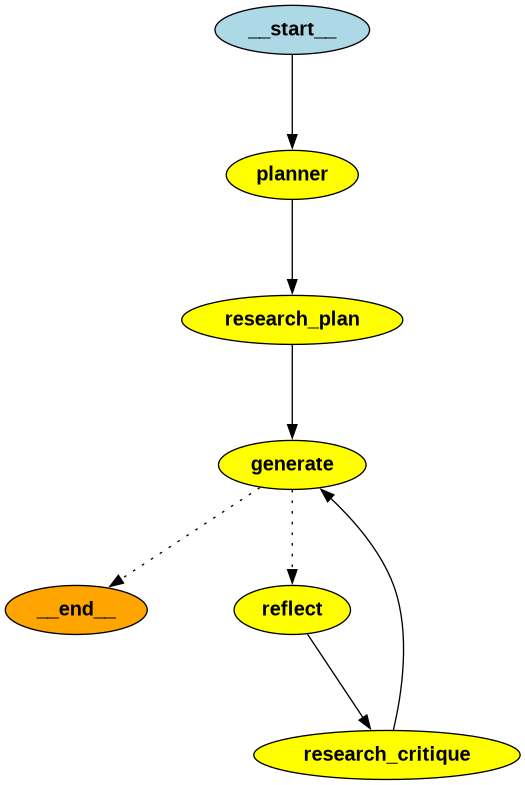

In [85]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

In [86]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith", 
    "max_revisions": 2,
    "revision_number": 1
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and purpose\n    B. Key features and functionalities\n    C. Use cases and applications\n    D. Advantages and limitations\n\nIII. Langsmith\n    A. Definition and purpose\n    B. Key features and functionalities\n    C. Use cases and applications\n    D. Advantages and limitations\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack and architecture\n    B. Scalability and performance\n    C. Security and privacy considerations\n    D. Adoption and popularity in the industry\n\nV. Conclusion\n    A. Recap of the main differences between Langchain and Langsmith\n    B. Implications for future developments in the field\n    C. Final thoughts on the significance of understanding these technologies.'}}
{'research_plan': {'content': ["This was such an important un